# Streaming Gaussian Mixture Model

## Update features when a new observation arrives

TODO

## Update the classifier

### General idea

Let $X = \{ x_1, \dotsc, x_N \}$ a collection of $N$ points. Now, lets suppose that the features of $x_j$ are updated, and lets call $x_j^{\star}$ the updated point. Lastly, lets define $X_{-j} = \{ x_1, \dotsc, x_{j-1}, x_{j+1}, \dotsc, x_N \}$.

The posterior before $x_j$ moves, and using $P(\Theta)$ as the prior is

$$P(\Theta \mid X) \propto P(X \mid \Theta)P(\Theta)$$,

where $P(X \mid \Theta) = \prod_i^N P(x_i \mid \Theta)$.

Now, after $x_j$ moves to $x_j^{\star}$, the posterior is

\begin{align*}
P(\Theta \mid X_{-j}, x_j^{\star}) &\propto P(X_{-j}, x_j^{\star} \mid \Theta)P(\Theta) \\
&\propto P(X_{-j} \mid \Theta)P(x_j^{\star} \mid \Theta)P(\Theta) \\
&\propto \frac{P(X \mid \Theta)}{P(x_j \mid \Theta)}P(x_j^{\star} \mid \Theta)P(\Theta) \\
&\propto \frac{P(x_j^{\star} \mid \Theta)}{P(x_j \mid \Theta)}P(X \mid \Theta)P(\Theta) \\
&\propto \frac{P(x_j^{\star} \mid \Theta)}{P(x_j \mid \Theta)}P(\Theta \mid X)
\end{align*}

### Mixture of GMM update

## Synthetic data generation

In the cell below we are going to generate synthetic data from multiple GMMs (one GMM per class).

In [18]:
import pandas as pd
import numpy as np
from scipy.stats import invwishart
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

import logging
logging.basicConfig(level=logging.DEBUG)

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(732839717)

sns.set(rc={"figure.figsize": (6, 6)})

CLASS_COLORS = ['#66c2a5',
                '#fc8d62',
                '#8da0cb',
                '#e78ac3',
                '#a6d854',
                '#ffd92f',
                '#e5c494',
                '#b3b3b3']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
class GMMDataGenerator:
     
    def __init__(self, m, k, d, mu_interval=(-10, 10), mu_var=(-4, 4),
                 cov_var=(-1, 1), gamma_0=3.0, alpha_0=5.0):
        """
        Args:
            k (int): number of components per class.
            d (int): dimension of data.
        """
        self.k = k
        self.d = d
        self._mu_0 = np.zeros(d)
        self.gamma_0 = gamma_0
        self.alpha_0 = alpha_0
        self.mu_interval = mu_interval
        self.mu_var = mu_var
        self.cov_var = cov_var
        self.mu = np.zeros((k, d))
        self.cov = np.zeros((k, d, d))
        self.sample_cov()
        self.sample_mean()
        self.weights = np.random.dirichlet(self.gamma_0 * np.ones(k))
        
    def generate(self, n=2000):
        X = np.zeros((n, self.d))
        Z = np.zeros(n)
        
        # generate the component distributions
        self.pi = np.random.dirichlet(self.alpha_0 * np.ones(self.k))
        for i in range(n):
            # generate random component of this observation
            z_i = np.argmax(np.random.multinomial(1, self.pi))
            Z[i] = z_i
             
            # generate the features
            X[i, :] = np.random.multivariate_normal(self.mu[z_i, :], 
                                                         self.cov[z_i, :])
        return X, Z.astype(int)
    
    def sample_cov(self):
        for j in range(self.k): 
            self.cov[j, :] = invwishart.rvs(2 * self.d, np.eye(self.d))
    
    def sample_from_component(self, k):
        return np.random.multivariate_normal(self.mu[k, :], 
                                             self.cov[k, :])
     
    def get_mu(self):
        return self.mu
    
    def get_cov(self):
        return self.cov
    
    def sample_mean(self):
        a, b = self.mu_interval
        std_min, std_max = self.cov_var
        mu_center = (b - a) * np.random.random(size=self.d) + a
        mu_max = mu_center + self.mu_var[1]
        mu_min = mu_center + self.mu_var[0]
        for j in range(self.k):
            mu_center_k = ((mu_max - mu_min) 
                           * np.random.random(size=self.d)
                           + mu_min)
            self.mu[j, :] = np.random.multivariate_normal(
                self._mu_0 + mu_center_k, self.cov[j, :])

In [20]:
def plot_gmm_obs(X, C, title='', ax=None):
    xlabel = 'x'
    ylabel = 'y'
    components = np.max(C) + 1
    for k in range(components):
        obs_of_k_component = np.where(C == k)[0]
        if ax:
            ax.scatter(X[obs_of_k_component, 0], X[obs_of_k_component, 1], 
                    facecolor=CLASS_COLORS[k], alpha=0.5,
                    edgecolor='black', linewidth=0.15)
        else:
            plt.scatter(X[obs_of_k_component, 0], X[obs_of_k_component, 1], 
                    facecolor=CLASS_COLORS[k], alpha=0.5,
                    edgecolor='black', linewidth=0.15)
    if ax:
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
    else:
        plt.title(title)
        #plt.legend()
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)


In [21]:
pal = sns.light_palette((200, 75, 60), input="husl", as_cmap=True)

def plot_gmm(X, mu, W, ax=None):
    assert mu.shape[0] == W.shape[0]
    dims = mu.shape[0]
    
    if ax:
        ax.scatter(X[:, 0], X[:, 1], 
                    alpha=0.5,
                    edgecolor='black', linewidth=0.15)
    else:
        plt.scatter(X[:, 0], X[:, 1], 
                    alpha=0.5,
                    edgecolor='black', linewidth=0.15)
    min_x, min_y = np.amin(X, axis=0)
    max_x, max_y = np.amax(X, axis=0)
    x, y = np.mgrid[min_x:max_x:0.1, min_y:max_y:0.1]
    z = np.zeros(x.shape + (2,))
    z[:, :, 0] = x;
    z[:, :, 1] = y
    for i in range(mu.shape[0]):
        f_z = scipy.stats.multivariate_normal.pdf(z, mu[i, :], W[i, :])
        if ax:
            ax.contour(x, y, f_z, antialiased=True, cmap=pal)
        else:
            plt.contour(x, y, f_z, antialiased=True, cmap=pal)

In [22]:
M = 1

# Number of components per class.
K = 3

# Dimension of data.
D = 2

#np.random.seed()

synthetic_gmm = GMMDataGenerator(m=M, k=K, d=D)
print('Mu:\n', synthetic_gmm.get_mu())
print('Cov:\n', synthetic_gmm.get_cov())

Mu:
 [[-13.4976689   -9.15391219]
 [ -8.52296015 -10.78440209]
 [ -8.01447974 -11.79393004]]
Cov:
 [[[ 0.87869225 -0.30782368]
  [-0.30782368  0.63133224]]

 [[ 2.1120209   0.36474583]
  [ 0.36474583  0.28096147]]

 [[ 0.8424209   0.99595504]
  [ 0.99595504  1.65430142]]]


# New data batch generation

In [23]:
n_batchs = 10

X_batchs = []
C_batchs = []
for i in range(n_batchs):
    new_X, new_C = synthetic_gmm.generate(n=200)
    X_batchs.append(new_X)
    C_batchs.append(new_C)

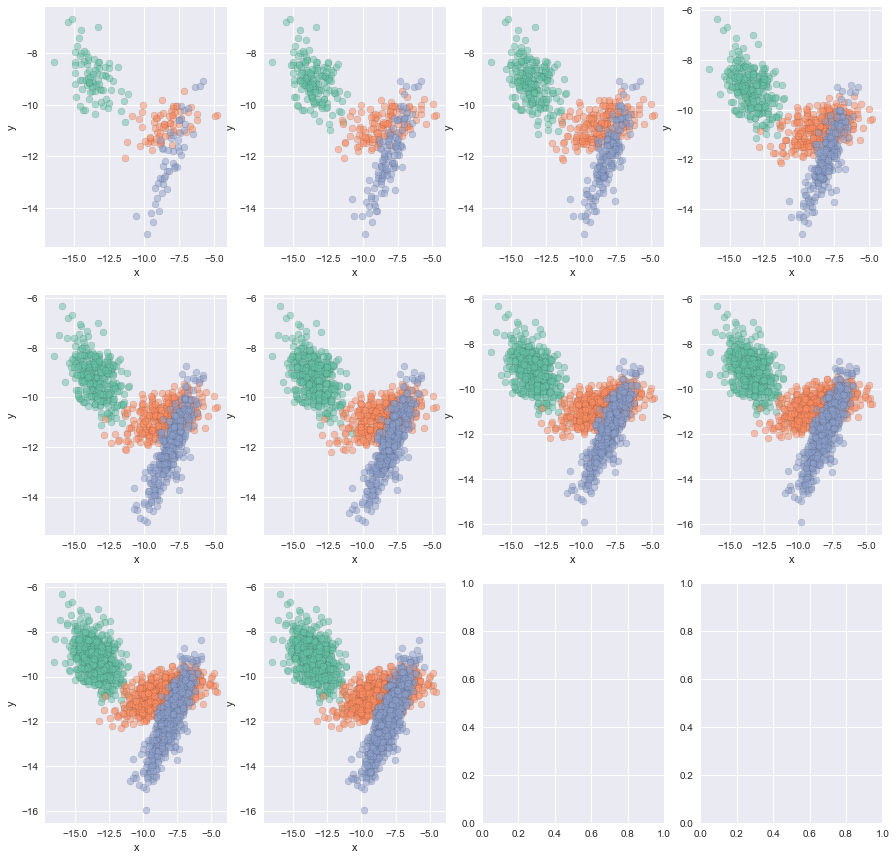

In [24]:
cols = 4
rows = n_batchs // cols + 1
f, ax = plt.subplots(rows, cols, figsize=(15, 15))
for i in range(rows):
    for j in range(cols):
        index = i * cols + j
        if index < n_batchs:
            plot_gmm_obs(np.concatenate(X_batchs[:index + 1]), 
                         np.concatenate(C_batchs[:index + 1]), 
                         ax=ax[i, j])
            #plot_gmm_obs(X_batchs[index], C_batchs[index], ax=ax[i, j])
plt.show()

In [25]:
import json

from streaming_gmm.streaming_variational_gmm import StreamingVariationalGMM, VariationalGMM

#prior =
#W_0 = 5 * np.eye(D)

result_list = []
debug_dict = {}
#streaming_vb_gmm = VariationalGMM(K, D)
for i in range(1, n_batchs + 1):
    #X = np.concatenate(X_batchs[:i])
    X = X_batchs[i-1]
    #streaming_vb_gmm.update_with_new_data(X)
    vbGmm = VariationalGMM(K, D, alpha_0=.01)
    vbGmm.fit(X, max_iter=20)
    #batch_result = streaming_vb_gmm.get_checkpoint()
    result_list.append(vbGmm.get_checkpoint())
#plot_gmm(X, vbGmm.m_k, np.linalg.inv(vbGmm.nu_k[:, np.newaxis, np.newaxis]*vbGmm.W_k))


debug_dict = {'checkpoints': []}
for result in result_list:
    new_dict = {}
    for k, v in result['variational_parameters'].items():
        new_dict[k] = np.array_str(v) 
    new_dict['pi_k_expec'] = np.array_str(result['pi_k_expectation'])
    debug_dict['checkpoints'].append(new_dict)

with open('logs/variational_gmm_results.json', 'w') as outfile:
    json.dump(debug_dict, outfile)

INFO:streaming_gmm.variational_gmm:Start fitting GMM in data
INFO:streaming_gmm.variational_gmm:Iteration: 0
INFO:streaming_gmm.variational_gmm:ELBO: -1000.975563
ERROR:streaming_gmm.variational_gmm:ELBO IS DECREASING!
ERROR:streaming_gmm.variational_gmm:ELBO IS DECREASING!
ERROR:streaming_gmm.variational_gmm:ELBO IS DECREASING!
ERROR:streaming_gmm.variational_gmm:ELBO IS DECREASING!
INFO:streaming_gmm.variational_gmm:Iteration: 5
INFO:streaming_gmm.variational_gmm:ELBO: -1005.510498
ERROR:streaming_gmm.variational_gmm:ELBO IS DECREASING!
INFO:streaming_gmm.variational_gmm:Iteration: 10
INFO:streaming_gmm.variational_gmm:ELBO: -973.896943
INFO:streaming_gmm.variational_gmm:Iteration: 15
INFO:streaming_gmm.variational_gmm:ELBO: -909.421610
INFO:streaming_gmm.variational_gmm:Finished inference. Elapsed time: 0 secs
DEBUG:streaming_gmm.variational_gmm:Variational mu:
[[-10.825291   -11.29932475]
 [ -8.01944838 -10.9731841 ]
 [-13.7521587   -8.93643868]]
DEBUG:streaming_gmm.variational_gmm

ERROR:streaming_gmm.variational_gmm:ELBO IS DECREASING!
INFO:streaming_gmm.variational_gmm:Finished inference. Elapsed time: 0 secs
DEBUG:streaming_gmm.variational_gmm:Variational mu:
[[ -8.15422817 -11.9064652 ]
 [ -8.45733718 -10.77473183]
 [-13.54763307  -9.16763749]]
DEBUG:streaming_gmm.variational_gmm:Variational W_k:
[[[ 0.04670814 -0.02168986]
  [-0.02168986  0.01787631]]

 [[ 0.00579063 -0.00696713]
  [-0.00696713  0.0337799 ]]

 [[ 0.0390242   0.0279854 ]
  [ 0.0279854   0.09420733]]]
INFO:streaming_gmm.variational_gmm:Start fitting GMM in data
INFO:streaming_gmm.variational_gmm:Iteration: 0
INFO:streaming_gmm.variational_gmm:ELBO: -944.456530
ERROR:streaming_gmm.variational_gmm:ELBO IS DECREASING!
ERROR:streaming_gmm.variational_gmm:ELBO IS DECREASING!
ERROR:streaming_gmm.variational_gmm:ELBO IS DECREASING!
ERROR:streaming_gmm.variational_gmm:ELBO IS DECREASING!
INFO:streaming_gmm.variational_gmm:Iteration: 5
INFO:streaming_gmm.variational_gmm:ELBO: -945.481092
INFO:streaming

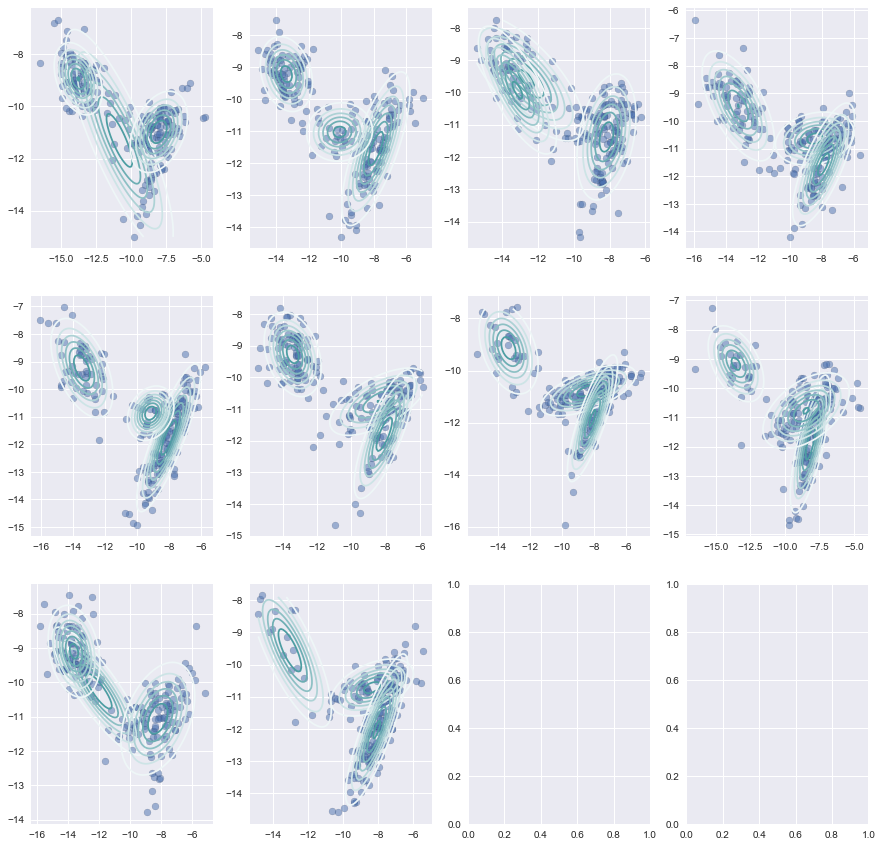

In [26]:
cols = 4
rows = n_batchs // cols + 1
f, ax = plt.subplots(rows, cols, figsize=(15, 15))
for i in range(rows):
    for j in range(cols):
        index = i * cols + j
        if index < n_batchs: 
            #X = np.concatenate(X_batchs[:index + 1])
            X = X_batchs[index]
            C = C_batchs[index]
            variational_params = result_list[index]['variational_parameters']
            m_k = variational_params['m_k']
            nu_k = variational_params['nu_k']
            W_k = variational_params['W_k']
            plot_gmm(X, 
                     m_k, 
                     np.linalg.inv(nu_k[:, np.newaxis, np.newaxis] * W_k),
                     ax=ax[i, j])
plt.show()

In [27]:
from streaming_gmm.streaming_variational_gmm import StreamingVariationalGMM, VariationalGMM

result_list = []
streaming_vb_gmm = StreamingVariationalGMM(K, D, alpha_0=.01)
for X, C in zip(X_batchs, C_batchs): 
    streaming_vb_gmm.update_with_new_data(X)
    #vbGmm = VariationalGMM(K, D)
    #vbGmm.fit(X, max_iter=20)
    #batch_result = streaming_vb_gmm.get_checkpoint()
    #result_list.append(streaming_vb_gmm.get_checkpoint())
result_list = streaming_vb_gmm.checkpoints
#plot_gmm(X, vbGmm.m_k, np.linalg.inv(vbGmm.nu_k[:, np.newaxis, np.newaxis]*vbGmm.W_k))

INFO:streaming_gmm.variational_gmm:Start fitting GMM in data
INFO:streaming_gmm.variational_gmm:Iteration: 0
INFO:streaming_gmm.variational_gmm:ELBO: -1001.160833
ERROR:streaming_gmm.variational_gmm:ELBO IS DECREASING!
ERROR:streaming_gmm.variational_gmm:ELBO IS DECREASING!
ERROR:streaming_gmm.variational_gmm:ELBO IS DECREASING!
INFO:streaming_gmm.variational_gmm:Iteration: 5
INFO:streaming_gmm.variational_gmm:ELBO: -994.066553
INFO:streaming_gmm.variational_gmm:Iteration: 10
INFO:streaming_gmm.variational_gmm:ELBO: -911.346461
INFO:streaming_gmm.variational_gmm:Iteration: 15
INFO:streaming_gmm.variational_gmm:ELBO: -877.775535
INFO:streaming_gmm.variational_gmm:Finished inference. Elapsed time: 0 secs
DEBUG:streaming_gmm.variational_gmm:Variational mu:
[[ -9.09244473 -10.62762491]
 [-13.7587839   -8.86028819]
 [ -8.21189948 -11.46556148]]
DEBUG:streaming_gmm.variational_gmm:Variational W_k:
[[[ 0.00765467  0.00155688]
  [ 0.00155688  0.09029458]]

 [[ 0.01874187  0.00809882]
  [ 0.008

ERROR:streaming_gmm.variational_gmm:ELBO IS DECREASING!
ERROR:streaming_gmm.variational_gmm:ELBO IS DECREASING!
INFO:streaming_gmm.variational_gmm:Iteration: 5
INFO:streaming_gmm.variational_gmm:ELBO: -961.688977
INFO:streaming_gmm.variational_gmm:Iteration: 10
INFO:streaming_gmm.variational_gmm:ELBO: -887.700520
INFO:streaming_gmm.variational_gmm:Iteration: 15
INFO:streaming_gmm.variational_gmm:ELBO: -883.778798
INFO:streaming_gmm.variational_gmm:Finished inference. Elapsed time: 0 secs
DEBUG:streaming_gmm.variational_gmm:Variational mu:
[[ -7.79133857 -11.10933941]
 [-12.26465655  -9.64553074]
 [-12.08129328 -10.20948069]]
DEBUG:streaming_gmm.variational_gmm:Variational W_k:
[[[ 0.01399263 -0.00751848]
  [-0.00751848  0.01417479]]

 [[ 0.01137131  0.02178717]
  [ 0.02178717  0.07567993]]

 [[ 0.01453275  0.01405023]
  [ 0.01405023  0.02170908]]]
DEBUG:streaming_gmm.streaming_variational_gmm:identify_components - real_m_k:
[[ -9.01417318 -10.80943772]
 [ -8.07155031 -11.65105603]
 [-1

INFO:streaming_gmm.variational_gmm:ELBO: -829.057911
INFO:streaming_gmm.variational_gmm:Finished inference. Elapsed time: 0 secs
DEBUG:streaming_gmm.variational_gmm:Variational mu:
[[ -7.95047061 -10.74610949]
 [-12.60871391  -9.71724954]
 [ -8.69183396 -12.48549254]]
DEBUG:streaming_gmm.variational_gmm:Variational W_k:
[[[ 0.00634892 -0.00759604]
  [-0.00759604  0.03454425]]

 [[ 0.0226015   0.0197527 ]
  [ 0.0197527   0.03284598]]

 [[ 0.10403378 -0.02106251]
  [-0.02106251  0.02990663]]]
DEBUG:streaming_gmm.streaming_variational_gmm:identify_components - real_m_k:
[[ -9.65781139 -10.6291399 ]
 [ -7.96418136 -11.52468109]
 [-13.31400503  -9.30274306]]
DEBUG:streaming_gmm.streaming_variational_gmm:identify_components - not iden:
[[ -7.95047061 -10.74610949]
 [-12.60871391  -9.71724954]
 [ -8.69183396 -12.48549254]]
DEBUG:streaming_gmm.streaming_variational_gmm:map_from_k_to_list: {0: [(0, 1.7113428689144714), (2, 2.0926436687958354), (1, 3.088587008844041)], 1: [(0, 0.7786923105318038

DEBUG:streaming_gmm.streaming_variational_gmm:identify_components - real_m_k:
[[ -9.94417728 -10.5171765 ]
 [ -7.98454774 -11.36224767]
 [-13.01040106  -9.53047072]]
DEBUG:streaming_gmm.streaming_variational_gmm:identify_components - not iden:
[[ -8.62726925 -10.73462529]
 [ -8.07540607 -11.96874275]
 [-13.51320843  -9.01248042]]
DEBUG:streaming_gmm.streaming_variational_gmm:map_from_k_to_list: {0: [(0, 1.3347399447377606), (1, 2.3662946540021048), (2, 3.8732536286557715)], 1: [(1, 0.61326301486625068), (0, 0.89833222517302513), (2, 6.0072868373513222)], 2: [(2, 0.72189279471027534), (0, 4.5455288656894561), (1, 5.5044841726924583)]}
DEBUG:streaming_gmm.streaming_variational_gmm:Mapped elements: {0: 0, 1: 1, 2: 2}
DEBUG:streaming_gmm.streaming_variational_gmm:correct components: {0: 0, 1: 1, 2: 2}
DEBUG:streaming_gmm.streaming_variational_gmm:alpha_k_old_data_delta:
[ 0.  0.  0.]
DEBUG:streaming_gmm.streaming_variational_gmm:beta_k_old_data_delta:
[ 0.  0.  0.]
DEBUG:streaming_gmm.stre

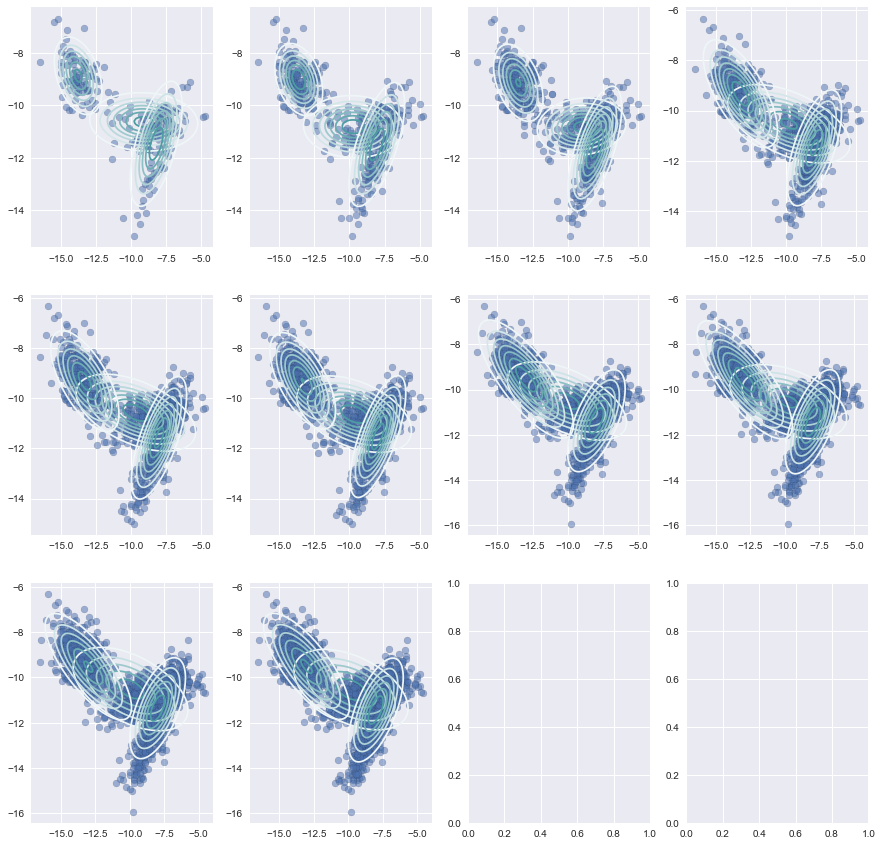

In [28]:
cols = 4
rows = n_batchs // cols + 1
f, ax = plt.subplots(rows, cols, figsize=(15, 15))
for i in range(rows):
    for j in range(cols):
        index = i * cols + j
        if index < n_batchs: 
            X = np.concatenate(X_batchs[:index + 1])
            #X = X_batchs[index]
            C = C_batchs[index]
            variational_params = result_list[index]['streaming_variational_parameters']
            m_k = variational_params['m_k']
            nu_k = variational_params['nu_k']
            W_k = variational_params['W_k']
            plot_gmm(X, 
                     m_k, 
                     np.linalg.inv(nu_k[:, np.newaxis, np.newaxis] * W_k),
                     ax=ax[i, j])
plt.show()


In [ ]:
print(np.squeeze(X[np.where(C == 0), :]).shape)

In [ ]:
%%time
from vbmm.varmix import run

mu, W, vk = run(np.squeeze(X[np.where(C == 0), :]), K)
W = np.asarray(W)

In [ ]:
print(np.linalg.inv(W))

In [ ]:
print(W.shape)
plot_gmm(X, mu, np.linalg.inv(vk[:, np.newaxis, np.newaxis]*W))
print(mu)
print(synthetic_gmm.get_mu())

In [ ]:
from vb_mgmm.var_bayes_gmm import VariationalGMM

In [ ]:
# We want to fail fast
np.seterr(all='raise')

In [ ]:
%%time
vbGmm = VariationalGMM(K, D)
print(vbGmm.get_model())
#vbGmm.get_model()
#vbGmm.fit(np.squeeze(X[np.where(C == 0), :]), max_iter=20, verbose=True)
#print('Real mu:\n', synthetic_gmm.get_mu())

In [ ]:
plot_gmm(X, vbGmm.m_k, np.linalg.inv(vbGmm.nu_k[:, np.newaxis, np.newaxis]*vbGmm.W_k))

In [ ]:
import vb_mgmm.streaming_vbgmm